# Preparación de datos

In [15]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display
from sklearn.impute import SimpleImputer

# Función para calcular el tamaño del objeto en MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

# Cargar el conjunto de datos
df = pd.read_csv('201501-hubway-tripdata.csv')
print('Dimensiones del conjunto de datos original: {0}; tamaño: {1}'.format(df.shape, size(df)))
display(df.head())

Dimensiones del conjunto de datos original: (7840, 15); tamaño: 4.30 MB


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,542,2015-01-01 00:21:44,2015-01-01 00:30:47,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,277,Subscriber,1984,1
1,438,2015-01-01 00:27:03,2015-01-01 00:34:21,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,95,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,648,Subscriber,1985,1
2,254,2015-01-01 00:31:31,2015-01-01 00:35:46,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,555,Subscriber,1974,1
3,432,2015-01-01 00:53:46,2015-01-01 01:00:58,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1307,Subscriber,1987,1
4,735,2015-01-01 01:07:06,2015-01-01 01:19:21,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,177,Customer,1986,2


## Manejo de datos

El código carga el CSV, identifica los valores faltantes (\\N) en la columna de año de nacimiento y los imputa mediante un método adecuado (SimpleImputer con una estrategia de mediana). Esto garantiza que el conjunto de datos esté limpio para el análisis.

In [16]:
# Manejo de valores faltantes
# Imputar el birth year con la mediana

# Reemplazar '\\N' por NaN en la columna 'birth year'
df['birth year'] = df['birth year'].replace('\\N', np.nan)

imputer = SimpleImputer(strategy='median')
df['birth year'] = imputer.fit_transform(df[['birth year']])

# Eliminar filas con cualquier otro valor faltante
df.dropna(inplace=True)

print('Dimensiones del conjunto de datos limpios: {0}; tamaño: {1}'.format(df.shape, size(df)))

Dimensiones del conjunto de datos limpios: (7840, 15); tamaño: 3.88 MB


## Transformación de datos

El uso de pd.melt para transformar los datos de un formato amplio (una fila por viaje) a un formato largo (una fila por estación dentro de un viaje) es el enfoque adecuado para este tipo de análisis. Convierte cada viaje en un "market basket" que contiene una estación de origen y una de destino, justo lo que necesita el algoritmo de la regla de asociación.

In [17]:
# Reformular los datos para el análisis de asociaciones
# Crear un trip_id único para cada viaje
df['trip_id'] = df.index

# Melt del DataFrame para obtener una lista de estaciones para cada viaje
trips = pd.melt(df, id_vars=['trip_id'], value_vars=['start station name', 'end station name'], value_name='station')
trips = trips.sort_values(by=['trip_id', 'variable']).drop(columns=['variable'])

# Convertir al formato esperado por las funciones: una Serie con trip_id como índice
orders = trips.set_index('trip_id')['station'].rename('item_id')
print('Dimensiones de datos transformados: {0}; size: {1}; unique_trips: {2}; unique_stations: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))
display(orders.head())

Dimensiones de datos transformados: (15680,); size: 1.67 MB; unique_trips: 7840; unique_stations: 58


,item_id
trip_id,
0,Cambridge Main Library at Broadway / Trowbridg...
0,Porter Square Station
1,Cambridge St - at Columbia St / Webster Ave
1,MIT Stata Center at Vassar St / Main St
2,Central Square at Mass Ave / Essex St


# I. Reglas de Asociación

## 1. La función association_rules calcula las tres métricas principales:

* Soporte: Frecuencia con la que una estación o un par de estaciones aparece en todos los viajes.
* Confianza: Probabilidad de que un viaje que comienza en la estación "A" termine en la estación "B".
* Incremento: Probabilidad de un viaje entre las estaciones "A" y "B" que si fueran independientes. Un incremento mayor a 1 indica una asociación fuerte.

In [21]:
# Funciones auxiliares para la minería de reglas de asociación
def freq(iterable):
    if isinstance(iterable, pd.core.series.Series):
        return iterable.value_counts().rename("freq")
    else:
        return pd.Series(Counter(iterable)).rename("freq")

def order_count(order_item):
    return len(set(order_item.index))

def get_item_pairs(order_item):
    order_item = order_item.reset_index().values
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
        for item_pair in combinations(item_list, 2):
            yield item_pair

def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
            .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
            .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))

# Función principal de reglas de asociación
def association_rules(order_item, min_support):
    print("Iniciando order_item: {:22d}".format(len(order_item))) # Iniciando order_item
    item_stats = freq(order_item).to_frame("freq")
    item_stats['support'] = item_stats['freq'] / order_count(order_item) * 100

    qualifying_items = item_stats[item_stats['support'] >= min_support].index
    order_item = order_item[order_item.isin(qualifying_items)]

    print("Elementos con soporte >= {}: {:15d}".format(min_support, len(qualifying_items))) # Elementos con soporte >=
    print("Restante order_item: {:21d}".format(len(order_item))) # order_item restante

    order_size = freq(order_item.index)
    qualifying_orders = order_size[order_size >= 2].index
    order_item = order_item[order_item.index.isin(qualifying_orders)]

    print("Ordenes restantes con 2+ elementos: {:11d}".format(len(qualifying_orders))) # Órdenes restantes con 2+ elementos
    print("Restante order_item: {:21d}".format(len(order_item))) # order_item restante

    item_stats = freq(order_item).to_frame("freq")
    item_stats['support'] = item_stats['freq'] / order_count(order_item) * 100

    item_pair_gen = get_item_pairs(order_item)
    item_pairs = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Pares de elementoss: {:31d}".format(len(item_pairs))) # Pares de elementos
    item_pairs = item_pairs[item_pairs['supportAB'] >= min_support]
    print("Pares de elementos con soporte >= {}: {:10d}\n".format(min_support, len(item_pairs))) # Pares de elementos con soporte >=

    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)

    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift'] = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])

    return item_pairs.sort_values('lift', ascending=False)

In [22]:
# Ejecutar el análisis
rules = association_rules(orders, 0.1)
display(rules.head(10))

Iniciando order_item:                  15680
Elementos con soporte >= 0.1:              36
Restante order_item:                 15628
Ordenes restantes con 2+ elementos:        7788
Restante order_item:                 15576
Pares de elementoss:                             777
Pares de elementos con soporte >= 0.1:        289



,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
153,Alewife Station at Russell Field,Linear Park - Mass. Ave. at Cameron Ave.,24,0.308166,125,1.605033,154,1.977401,0.192000,0.155844,0.097097
157,Linear Park - Mass. Ave. at Cameron Ave.,Alewife Station at Russell Field,18,0.231125,154,1.977401,125,1.605033,0.116883,0.144000,0.072823
154,Alewife Station at Russell Field,Alewife Station at Russell Field,10,0.128403,125,1.605033,125,1.605033,0.080000,0.080000,0.049843
14,Porter Square Station,Danehy Park,35,0.449409,529,6.792501,152,1.951721,0.066163,0.230263,0.033900
62,Danehy Park,Porter Square Station,33,0.423729,152,1.951721,529,6.792501,0.217105,0.062382,0.031962
59,Harvard Square at Brattle St / Eliot St,Harvard University Radcliffe Quadrangle at She...,50,0.642013,347,4.455573,364,4.673857,0.144092,0.137363,0.030829
128,Harvard Kennedy School at Bennett St / Eliot St,Harvard University Housing - 115 Putnam Ave at...,55,0.706215,295,3.787879,492,6.317411,0.186441,0.111789,0.029512
198,Cambridge Main Library at Broadway / Trowbridg...,Rindge Avenue - O'Neill Library,13,0.166923,586,7.524397,67,0.860298,0.022184,0.194030,0.025787
192,Harvard Kennedy School at Bennett St / Eliot St,Harvard Law School at Mass Ave / Jarvis St,28,0.359527,295,3.787879,318,4.083205,0.094915,0.088050,0.023245
69,EF - North Point Park,Lechmere Station at Cambridge St / First St,22,0.282486,204,2.619414,380,4.879301,0.107843,0.057895,0.022102


## 2. Segmentación de clientes

Al dividir el análisis entre suscriptores y clientes, el c+odigo ya detecta diferentes patrones de comportamiento.

In [26]:
# Segmentación por tipo de usuario
subscribers = df[df['usertype'] == 'Subscriber'].copy()
customers = df[df['usertype'] == 'Customer'].copy()

# Crear datos de viaje para suscriptores
subscribers['trip_id'] = subscribers.index
sub_trips = pd.melt(subscribers, id_vars=['trip_id'], value_vars=['start station name', 'end station name'], value_name='station')
sub_trips = sub_trips.sort_values(by=['trip_id', 'variable']).drop(columns=['variable'])
sub_orders = sub_trips.set_index('trip_id')['station'].rename('item_id')

# Crear datos de viaje para los clientes
customers['trip_id'] = customers.index
cust_trips = pd.melt(customers, id_vars=['trip_id'], value_vars=['start station name', 'end station name'], value_name='station')
cust_trips = cust_trips.sort_values(by=['trip_id', 'variable']).drop(columns=['variable'])
cust_orders = cust_trips.set_index('trip_id')['station'].rename('item_id')

# Ejecutar análisis para suscriptores
print("--- Análisis para suscriptores ---")
sub_rules = association_rules(sub_orders, 0.1)
display(sub_rules.head())

# Ejecutar análisis para clientes
print("\n--- Análisis para clientes ---")
cust_rules = association_rules(cust_orders, 0.1)
display(cust_rules.head())

--- Análisis para suscriptores ---
Iniciando order_item:                  10968
Elementos con soporte >= 0.1:              37
Restante order_item:                 10926
Ordenes restantes con 2+ elementos:        5442
Restante order_item:                 10884
Pares de elementoss:                             709
Pares de elementos con soporte >= 0.1:        270



,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
93,Kenmore Sq / Comm Ave,MIT at Mass Ave / Amherst St,6,0.110254,6,0.110254,885,16.262404,1.000000,0.006780,0.061492
165,Harvard Square at Brattle St / Eliot St,Harvard University Radcliffe Quadrangle at She...,37,0.679897,242,4.446895,223,4.097758,0.152893,0.165919,0.037311
10,Porter Square Station,Danehy Park,29,0.532892,357,6.560088,120,2.205072,0.081232,0.241667,0.036839
45,Danehy Park,Porter Square Station,28,0.514517,120,2.205072,357,6.560088,0.233333,0.078431,0.035569
153,Cambridge Main Library at Broadway / Trowbridg...,Rindge Avenue - O'Neill Library,13,0.238883,414,7.607497,58,1.065785,0.031401,0.224138,0.029463



--- Análisis para clientes ---
Iniciando order_item:                   4712
Elementos con soporte >= 0.1:              34
Restante order_item:                  4704
Ordenes restantes con 2+ elementos:        2348
Restante order_item:                  4696
Pares de elementoss:                             483
Pares de elementos con soporte >= 0.1:        228



,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
59,Alewife Station at Russell Field,Linear Park - Mass. Ave. at Cameron Ave.,19,0.809199,73,3.109029,58,2.470187,0.260274,0.327586,0.105366
62,Linear Park - Mass. Ave. at Cameron Ave.,Alewife Station at Russell Field,14,0.596252,58,2.470187,73,3.109029,0.241379,0.191781,0.077638
48,Rindge Avenue - O'Neill Library,Porter Square Station,4,0.170358,9,0.383305,172,7.325383,0.444444,0.023256,0.060672
3,Christian Science Plaza,Inman Square at Vellucci Plaza / Hampshire St,5,0.212947,9,0.383305,270,11.499148,0.555556,0.018519,0.048313
4,Harvard University Radcliffe Quadrangle at She...,Harvard University Gund Hall at Quincy St / Ki...,27,1.149915,141,6.005111,102,4.344123,0.191489,0.264706,0.044080


# II. Segmentación de Clientes con K-Means

## 1. Funciones Centradas en el Usuario:

Primero, necesitamos transformar los datos de viajes a un formato basado en el usuario. Se creará un perfil para cada usuario que resuma su comportamiento. Las características clave incluirán:

* total_trips: Número total de viajes realizados.

* average_duration: Duración promedio de sus viajes en segundos.

* subscriber_status: Si el usuario es "Subscriber" (Suscriptor) o "Customer" (Cliente), codificación one-hot.

* Station Usage: Cuántas veces ha iniciado un viaje desde cada una de las estaciones principales. Esto conecta el análisis de asociación con el modelo de clusterización.

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Ingeniería de Características para Clustering ---

# Crear un identificador de usuario único. Dado que no tenemos un ID de usuario estable,
# crearemos un proxy basado en las características del usuario.
# Nota: Esta es una aproximación para este conjunto de datos específico.
df['user_proxy_id'] = df['usertype'] + '_' + df['birth year'].astype(str) + '_' + df['gender'].astype(str)

# Agregar datos de viaje a nivel de usuario
user_df = df.groupby('user_proxy_id').agg(
    total_trips=('trip_id', 'count'),
    average_duration=('tripduration', 'mean'),
    usertype=('usertype', 'first')
).reset_index()

# Codificación one-hot de la columna 'usertype' para el modelo
user_df = pd.get_dummies(user_df, columns=['usertype'], prefix='', prefix_sep='')

# Identificar las estaciones de inicio más populares para usar como características
top_stations = df['start station name'].value_counts().nlargest(10).index

# Crear una tabla pivote para contar cuántas veces cada usuario comenzó un viaje desde una estación principal
user_station_usage = df[df['start station name'].isin(top_stations)].pivot_table(
    index='user_proxy_id',
    columns='start station name',
    values='trip_id',
    aggfunc='count',
    fill_value=0
)

# Fusionar los datos de usuario agregados con los datos de uso de estaciones
cluster_df = pd.merge(user_df, user_station_usage, on='user_proxy_id', how='left').fillna(0)

print("Shape of the feature-engineered DataFrame for clustering:", cluster_df.shape) # Forma del DataFrame con características diseñadas para clustering
display(cluster_df.head())

Shape of the feature-engineered DataFrame for clustering: (169, 15)


,user_proxy_id,total_trips,average_duration,Customer,Subscriber,359 Broadway - Broadway at Fayette Street,Ames St at Main St,Cambridge Main Library at Broadway / Trowbridge St,Cambridge St - at Columbia St / Webster Ave,Central Sq Post Office / Cambridge City Hall at Mass Ave / Pleasant St,Central Square at Mass Ave / Essex St,Inman Square at Vellucci Plaza / Hampshire St,MIT Stata Center at Vassar St / Main St,MIT at Mass Ave / Amherst St,One Kendall Square at Hampshire St / Portland St
0,Customer_1900.0_1,1,313.000000,True,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Customer_1946.0_1,23,710.173913,True,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Customer_1947.0_1,5,265.800000,True,False,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Customer_1948.0_1,9,479.222222,True,False,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,Customer_1950.0_1,9,590.222222,True,False,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 2. Encontrar el número óptimo de Clusters (método del codo)

Se utilizará el método del Codo, una técnica clásica en la que calculamos K-Means para un rango de k valores y graficamos la suma de cuadrados dentro del cluster (WCSS - "within-cluster sum of squares" ).

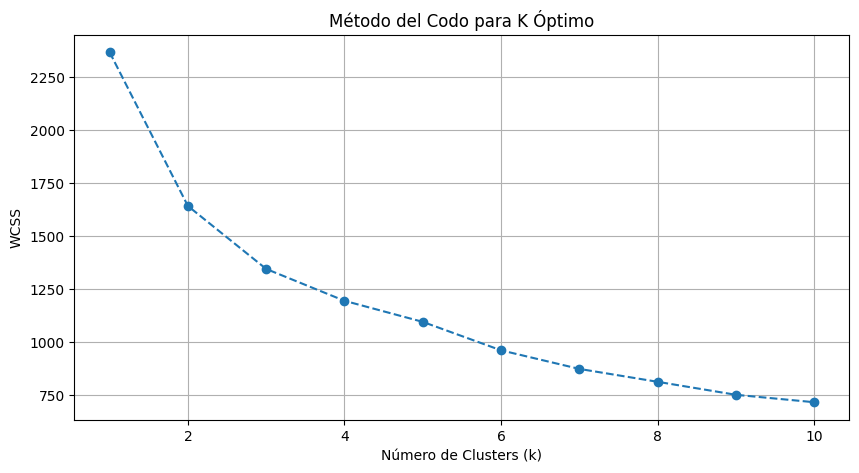

In [28]:
# --- Encontrando el K Óptimo ---

# Seleccionar solo las características numéricas para clustering
features_for_clustering = cluster_df.drop(columns=['user_proxy_id'])

# Es crucial escalar los datos para que K-Means funcione eficazmente
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Calcular WCSS para un rango de valores de k
wcss = []
k_range = range(1, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Método del Codo para K Óptimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

## 3. Aplicar K-Means y analizar segmentos

Con base en el gráfico de codo, seleccionaremos un k óptimo (normalmente donde la tasa de disminución cambia bruscamente) y ejecutaremos el algoritmo K-Means final.

In [30]:
# --- Aplicando K-Means y Analizando Segmentos ---

# Se elige k=4 basándonos en el codo visual del gráfico
optimal_k = 4

# Ejecutar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(scaled_features)

print(f"Usuarios segmentados con éxito en {optimal_k} clusters.") # Usuarios segmentados con éxito en X clusters.
display(cluster_df.head())

Usuarios segmentados con éxito en 4 clusters.


,user_proxy_id,total_trips,average_duration,Customer,Subscriber,359 Broadway - Broadway at Fayette Street,Ames St at Main St,Cambridge Main Library at Broadway / Trowbridge St,Cambridge St - at Columbia St / Webster Ave,Central Sq Post Office / Cambridge City Hall at Mass Ave / Pleasant St,Central Square at Mass Ave / Essex St,Inman Square at Vellucci Plaza / Hampshire St,MIT Stata Center at Vassar St / Main St,MIT at Mass Ave / Amherst St,One Kendall Square at Hampshire St / Portland St,cluster
0,Customer_1900.0_1,1,313.000000,True,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,Customer_1946.0_1,23,710.173913,True,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,Customer_1947.0_1,5,265.800000,True,False,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Customer_1948.0_1,9,479.222222,True,False,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0
4,Customer_1950.0_1,9,590.222222,True,False,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


# III. Diseño de ingeniería de características

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Convertir columnas de fecha y hora para el cálculo de la recencia
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
reference_date = pd.to_datetime('2015-12-31 23:59:59')

## 1. Spending Score / Puntuación de Gasto:

* Frecuencia (F): Total de viajes por usuario. A mayor frecuencia, mayor uso.
* Recencia (R): Días desde el último viaje. Invertido para penalizar la inactividad.
* Monetario (M): Duración total del viaje. A mayor frecuencia, mayor potencial de ingresos.
* Fórmula: 0,4*F_norm + 0,4*M_norm + 0,2*R_factor.
* Ponderaciones (α=0,4, β=0,4, γ=0,2): Prioriza la frecuencia y el valor monetario sobre la actualidad.

In [33]:
# --- Calcular Puntuación de Gasto (RFM) ---
user_rfm = df.groupby('user_proxy_id').agg(
    frequency=('trip_id', 'count'),  # Frecuencia: total de viajes
    monetary=('tripduration', 'sum'), # Monetario: duración total
    last_trip=('stoptime', 'max')     # Fecha del último viaje para la recencia
).reset_index()

# Recencia: días desde el último viaje hasta el final de rango de fecha (invertido para la puntuación)
user_rfm['recency_days'] = (reference_date - user_rfm['last_trip']).dt.days

# Normalizar métricas RFM (rango 0-1)
scaler = MinMaxScaler()
user_rfm[['F_norm', 'M_norm', 'R_norm']] = scaler.fit_transform(
    user_rfm[['frequency', 'monetary', 'recency_days']]
)

# Invertir recencia: Mayor valor = actividad más reciente
user_rfm['R_factor'] = 1 - user_rfm['R_norm']

# Puntuación de Gasto = α*F + β*M + γ*R (α=0.4, β=0.4, γ=0.2)
user_rfm['spending_score'] = (
    0.4 * user_rfm['F_norm'] +
    0.4 * user_rfm['M_norm'] +
    0.2 * user_rfm['R_factor']
)

## 2. Annual Income Proxy / Proxy de Ingresos Anuales:

* Cálculo de Edad: 2015 - año de referencia.

* Franjas de Edad:
  * 0-17: Adolescentes (probablemente estudiantes).
  * 18-24: Adultos jóvenes (empleos de nivel inicial).
  * 25-44: Edad laboral óptima.
  * 45-64: Carreras profesionales consolidadas.
  * 65+: Edad de jubilación.

* Franja de Ingresos Base:

  * Bajo: Score < 0,33.
  * Medio: 0,33 ≤ Score < 0,66.
  * Alto: Score ≥ 0,66.

* Refinamiento:

  * Mejorar: Usuarios con ≥1 viaje premium.
  * Degradación: Usuarios jóvenes/mayores sin viajes premium.

## 3. Integración de Reglas de Asociación:

 * Reglas Premium: Patrones de alto valor (lift > 1 y confidence > 0,5).
 * Recuento Premium: Total de viajes que cumplen con las reglas premium. Se utiliza para mejorar la banda de ingresos.

In [34]:
# --- Identificar Reglas de Asociación Premium ---
# Definir reglas "premium" (lift > 1, confidence > 0.5)
premium_rules = rules[(rules['lift'] > 1) & ((rules['confidenceAtoB'] > 0.5) | (rules['confidenceBtoA'] > 0.5))]
premium_pairs = set(zip(
    premium_rules['item_A'],
    premium_rules['item_B']
))

# Marcar viajes premium en el conjunto de datos
df['is_premium_trip'] = df.apply(
    lambda row: (row['start station name'], row['end station name']) in premium_pairs,
    axis=1
)

# Contar viajes premium por usuario
premium_counts = df.groupby('user_proxy_id')['is_premium_trip'].sum().reset_index()
premium_counts.rename(columns={'is_premium_trip': 'premium_count'}, inplace=True)

In [36]:
# --- Calcular Proxy de Ingresos Anuales ---
# Cálculo de la edad (2015 - año de referencia)
user_demographics = df.groupby('user_proxy_id').first()[['birth year', 'usertype']].reset_index()
user_demographics['age'] = 2015 - user_demographics['birth year']

# Rangos de edad (bins personalizados)
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
user_demographics['age_band'] = pd.cut(
    user_demographics['age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

# Rango de ingresos base a partir de la puntuación de gasto
def assign_base_income(score):
    if score < 0.33: return 'Low'
    elif score < 0.66: return 'Medium'
    else: return 'High'

user_rfm['base_income_band'] = user_rfm['spending_score'].apply(assign_base_income)

# Fusionar todas las características a nivel de usuario
user_data = user_rfm.merge(user_demographics, on='user_proxy_id', how='left')
user_data = user_data.merge(premium_counts, on='user_proxy_id', how='left')

# Refinar el rango de ingresos utilizando premium_count y age_band
def refine_income_band(row):
    base_band = row['base_income_band']
    premium_count = row['premium_count']
    age_band = row['age_band']

    # Mejorar si el usuario tiene viajes premium
    if premium_count >= 1:
        if base_band == 'Low':
            return 'Medium'
        elif base_band == 'Medium':
            return 'High'

    # Degradación para usuarios jóvenes/mayores sin viajes premium
    if age_band in ['0-17', '18-24', '65+'] and base_band == 'High':
        return 'Medium'

    return base_band

user_data['income_band'] = user_data.apply(refine_income_band, axis=1)

# Mostrar las características finales del usuario
print(user_data[['user_proxy_id', 'spending_score', 'premium_count', 'income_band']].head())

       user_proxy_id  spending_score  premium_count income_band
0  Customer_1900.0_1        0.157237              0         Low
1  Customer_1946.0_1        0.165576              0         Low
2  Customer_1947.0_1        0.128119              0         Low
3  Customer_1948.0_1        0.200467              0         Low
4  Customer_1950.0_1        0.172640              0         Low


# IV. Visualización de datos

In [38]:
# --- Ingeniería de Características: Métricas a Nivel de Usuario y Clustering ---
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Para gráficos de dispersión 3D

# Extraer la edad del año de nacimiento (2015 año de referencia)
df['age'] = 2015 - df['birth year'].astype(float)

# Agregar características a nivel de usuario
user_agg = df.groupby('user_proxy_id').agg(
    total_trips=('trip_id', 'count'),
    avg_duration=('tripduration', 'mean'),
    gender=('gender', 'first'),
    age=('age', 'first')
).reset_index()

# Diseñar características:
# - Proxy de ingresos anuales: Relación lineal asumida con la edad
# - Puntuación de gasto: Total de minutos de viaje (viajes * duración promedio)
user_agg['annual_income_proxy'] = user_agg['age'] * 500  # Factor de escala arbitrario
user_agg['spending_score'] = user_agg['total_trips'] * user_agg['avg_duration']

# Escalar características para K-Means
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_agg[['total_trips', 'avg_duration', 'annual_income_proxy', 'spending_score']])

# Aplicar clustering K-Means (k=5 del método del codo)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
user_agg['cluster'] = kmeans.fit_predict(scaled_features)

## 1. Funciones de exploración reutilizables

In [11]:
# --- Funciones de Exploración Reutilizables ---
def explore_trips(trip_df):
    """
    Realiza EDA y visualización exhaustiva para datos a nivel de viaje.
    Incluye estadísticas de resumen, mapa de calor de correlación, matriz de dispersión
    y visualizaciones personalizadas.
    """
    # 1. Estadísticas de Resumen
    print("Resumen de Datos de Viaje:") # Resumen de Datos de Viaje:
    summary = trip_df.describe(include='all').T
    summary['missing'] = trip_df.isnull().sum()
    summary['unique'] = trip_df.nunique()
    display(summary)

    # 2. Mapa de Calor de Correlación (Características Numéricas)
    numeric_cols = trip_df.select_dtypes(include=np.number).columns.tolist()
    corr_matrix = trip_df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.title('Mapa de Calor de Correlación') # Mapa de Calor de Correlación
    plt.show()

    # 3. Matriz de Dispersión Pairwise
    pd.plotting.scatter_matrix(
        trip_df[['tripduration', 'start station latitude', 'start station longitude']],
        figsize=(12, 10),
        diagonal='kde'
    )
    plt.suptitle('Matriz de Dispersión Pairwise') # Matriz de Dispersión Pairwise
    plt.show()

    # 4. Análisis de Uso de Estaciones
    start_counts = trip_df['start station name'].value_counts().head(20)
    end_counts = trip_df['end station name'].value_counts().head(20)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    start_counts.plot(kind='bar', ax=ax[0], title='Top 20 Estaciones (Salidas)') # Top 20 Estaciones (Salidas)
    end_counts.plot(kind='bar', ax=ax[1], title='Top 20 Estaciones (Llegadas)') # Top 20 Estaciones (Llegadas)
    plt.tight_layout()
    plt.show()

    # 5. Análisis de Distribución de Viajes
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    trip_df['tripduration'].plot(kind='hist', bins=50, ax=ax[0], title='Distribución de la Duración del Viaje') # Distribución de la Duración del Viaje
    ax[0].set_xlabel('Duración (segundos)') # Duración (segundos)

    # Convertir a datetime y graficar viajes diarios
    trip_df['starttime'] = pd.to_datetime(trip_df['starttime'])
    trip_df.set_index('starttime')['trip_id'].resample('D').count().plot(
        ax=ax[1], title='Volumen Diario de Viajes' # Volumen Diario de Viajes
    )
    ax[1].set_ylabel('Viajes por Día') # Viajes por Día
    plt.tight_layout()
    plt.show()

    # 6. Boxplot de Duración por Género
    trip_df.boxplot(column='tripduration', by='gender', figsize=(10, 6))
    plt.title('Duración del Viaje por Género') # Duración del Viaje por Género
    plt.suptitle('')
    plt.xlabel('Género (1=Hombre, 2=Mujer)') # Género (1=Hombre, 2=Mujer)
    plt.ylabel('Duración (segundos)') # Duración (segundos)
    plt.show()

    # 7. Análisis Conjunto: Uso vs Duración
    station_stats = trip_df.groupby('start station name').agg(
        usage=('start station id', 'count'),
        avg_duration=('tripduration', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 6))
    plt.scatter(
        station_stats['usage'],
        station_stats['avg_duration'],
        s=station_stats['usage']/10,  # Tamaño de la burbuja por uso
        alpha=0.5
    )
    plt.title('Uso de Estaciones vs. Duración Promedio') # Uso de Estaciones vs. Duración Promedio
    plt.xlabel('Total de Viajes (Salidas + Llegadas)') # Total de Viajes (Salidas + Llegadas)
    plt.ylabel('Duración Promedio (segundos)') # Duración Promedio (segundos)
    plt.grid(True)
    plt.show()

    # 8. Comparación de Género
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Uso de estaciones por género
    gender_usage = trip_df.groupby('gender')['start station name'].count()
    gender_usage.plot(kind='pie', autopct='%1.1f%%', ax=axes[0], title='Volumen de Viajes por Género') # Volumen de Viajes por Género

    # Distribución de duración por género
    for gender in [1, 2]:
        subset = trip_df[trip_df['gender'] == gender]
        subset['tripduration'].plot(
            kind='kde',
            ax=axes[1],
            label=f'Género {gender}' # Género
        )
    axes[1].set_title('Distribución de Duración por Género') # Distribución de Duración por Género
    axes[1].legend()

    # Viajes diarios por género
    for gender in [1, 2]:
        subset = trip_df[trip_df['gender'] == gender]
        subset.set_index('starttime')['trip_id'].resample('D').count().plot(
            ax=axes[2],
            label=f'Género {gender}' # Género
        )
    axes[2].set_title('Viajes Diarios por Género') # Viajes Diarios por Género
    axes[2].legend()
    plt.tight_layout()
    plt.show()

In [39]:
def visualize_users(user_df):
    """
    Genera visualizaciones a nivel de usuario incluyendo demografía,
    patrones de ingresos/gastos y relaciones de cluster.
    """
    # 1. Distribución de Edad
    plt.figure(figsize=(10, 6))
    plt.hist(user_df['age'], bins=20, density=True, alpha=0.7)
    user_df['age'].plot(kind='kde', color='red', secondary_y=True)
    plt.title('Distribución de Edad') # Distribución de Edad
    plt.xlabel('Edad') # Edad
    plt.show()

    # 2. Desglose por Género
    gender_counts = user_df['gender'].value_counts()
    plt.figure(figsize=(10, 5))
    gender_counts.plot(kind='bar', title='Conteo de Usuarios por Género') # Conteo de Usuarios por Género
    plt.xticks(ticks=[0,1], labels=['Hombre', 'Mujer'], rotation=0) # Hombre, Mujer
    plt.ylabel('Conteo') # Conteo
    plt.show()

    # 3. Análisis del Proxy de Ingresos
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    user_df['annual_income_proxy'].plot(kind='hist', bins=20, ax=ax[0], title='Distribución del Proxy de Ingresos') # Distribución del Proxy de Ingresos
    user_df.boxplot(column='annual_income_proxy', by='cluster', ax=ax[1])
    plt.suptitle('')
    ax[1].set_title('Proxy de Ingresos por Cluster') # Proxy de Ingresos por Cluster
    plt.tight_layout()
    plt.show()

    # 4. Análisis de la Puntuación de Gasto
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    user_df['spending_score'].plot(kind='hist', bins=20, ax=ax[0], title='Distribución de la Puntuación de Gasto') # Distribución de la Puntuación de Gasto
    user_df.boxplot(column='spending_score', by='cluster', ax=ax[1])
    plt.suptitle('')
    ax[1].set_title('Puntuación de Gasto por Cluster') # Puntuación de Gasto por Cluster
    plt.tight_layout()
    plt.show()

    # 5. Análisis Conjunto: Edad-Ingresos-Gasto
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in sorted(user_df['cluster'].unique()):
        cluster_data = user_df[user_df['cluster'] == cluster]
        ax.scatter(
            cluster_data['age'],
            cluster_data['annual_income_proxy'],
            cluster_data['spending_score'],
            s=50,
            label=f'Cluster {cluster}' # Cluster
        )

    ax.set_xlabel('Edad') # Edad
    ax.set_ylabel('Proxy de Ingresos') # Proxy de Ingresos
    ax.set_zlabel('Puntuación de Gasto') # Puntuación de Gasto
    plt.title('Relación de Cluster 3D') # Relación de Cluster 3D
    plt.legend()
    plt.show()

    # 6. Distribuciones Específicas por Género
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Edad por género
    for gender in [1, 2]:
        subset = user_df[user_df['gender'] == gender]
        subset['age'].plot(kind='kde', ax=axes[0], label=f'Género {gender}') # Género
    axes[0].set_title('Distribución de Edad por Género') # Distribución de Edad por Género
    axes[0].legend()

    # Ingresos por género - establecer número de ticks
    user_df.boxplot(column='annual_income_proxy', by='gender', ax=axes[1])
    axes[1].set_title('Proxy de Ingresos por Género') # Proxy de Ingresos por Género
    axes[1].set_xticks([1, 2])  # Establecer explícitamente 2 posiciones de tick
    axes[1].set_xticklabels(['Hombre', 'Mujer']) # Hombre, Mujer

    # Gasto por género - establecer número de ticks
    user_df.boxplot(column='spending_score', by='gender', ax=axes[2])
    axes[2].set_title('Puntuación de Gasto por Género') # Puntuación de Gasto por Género
    axes[2].set_xticks([1, 2])  # Establecer explícitamente 2 posiciones de tick
    axes[2].set_xticklabels(['Hombre', 'Mujer']) # Hombre, Mujer

    plt.suptitle('')
    plt.tight_layout()
    plt.show()

## 2. Ejecución de funciones de visualización

Resumen de Datos de Viaje:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std,missing
tripduration,7840.0,1383,NaN,NaN,647.878444,62.0,287.0,406.0,602.0,232319.0,3998.551965,0
starttime,7840,7822,NaN,NaN,2015-01-16 13:47:47.360331776,2015-01-01 00:21:44,2015-01-09 18:04:58.249999872,2015-01-16 17:33:30.500000,2015-01-22 12:30:51.500000,2015-01-31 23:21:57,NaN,0
stoptime,7840,7812,NaN,NaN,2015-01-16 13:58:35.742091776,2015-01-01 00:30:47,2015-01-09 18:15:10.750000128,2015-01-16 17:42:21.500000,2015-01-22 12:39:18.750000128,2015-01-31 23:28:06,NaN,0
start station id,7840.0,32,NaN,NaN,91.928954,67.0,75.0,89.5,107.0,145.0,19.303781,0
start station name,7840,32,Ames St at Main St,564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
start station latitude,7840.0,32,NaN,NaN,42.369236,42.356954,42.363465,42.366621,42.373268,42.397828,0.008205,0
start station longitude,7840.0,32,NaN,NaN,-71.10221,-71.139459,-71.114214,-71.101427,-71.09169,-71.069957,0.014306,0
end station id,7840.0,58,NaN,NaN,90.985459,1.0,74.0,89.0,107.0,149.0,20.584012,0
end station name,7840,58,MIT at Mass Ave / Amherst St,581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
end station latitude,7840.0,58,NaN,NaN,42.368961,42.334876,42.362613,42.366621,42.373268,42.397828,0.008531,0


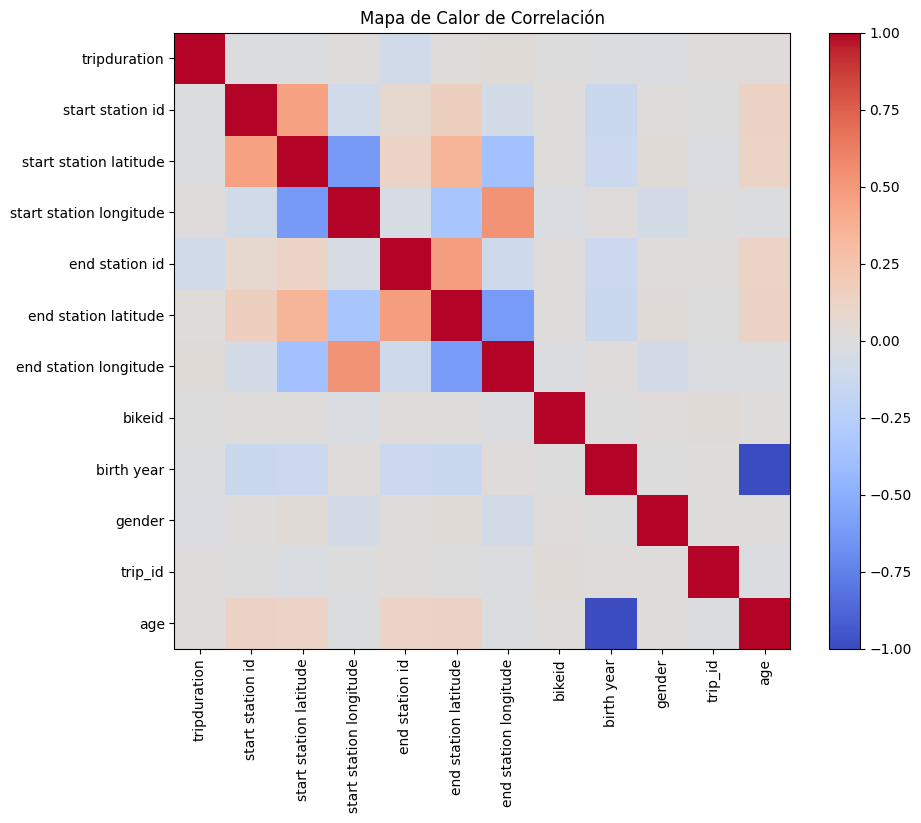

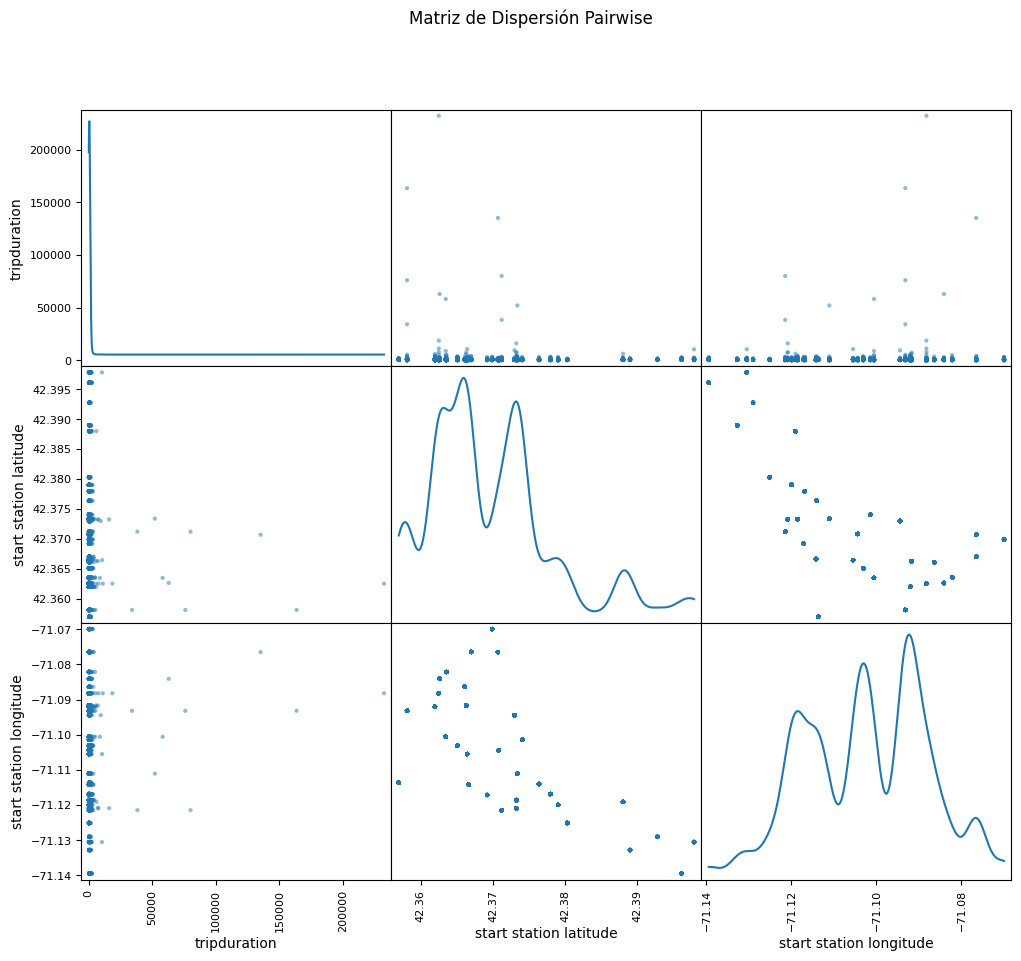

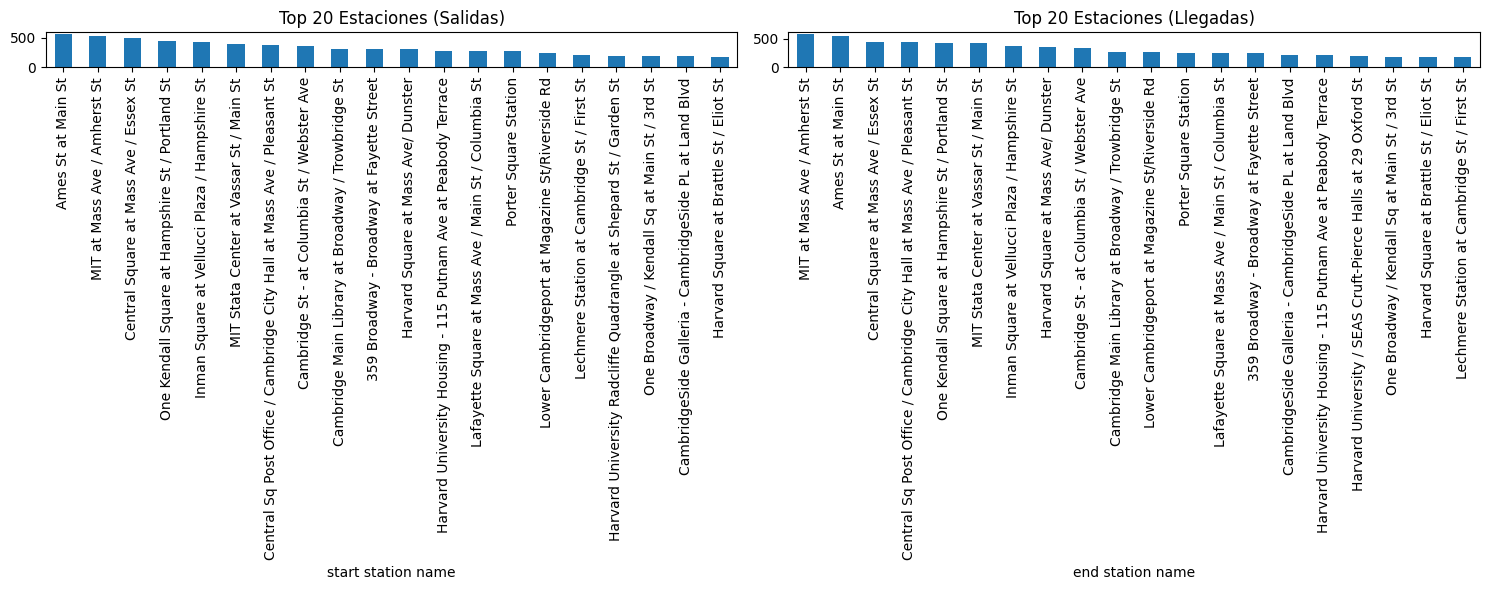

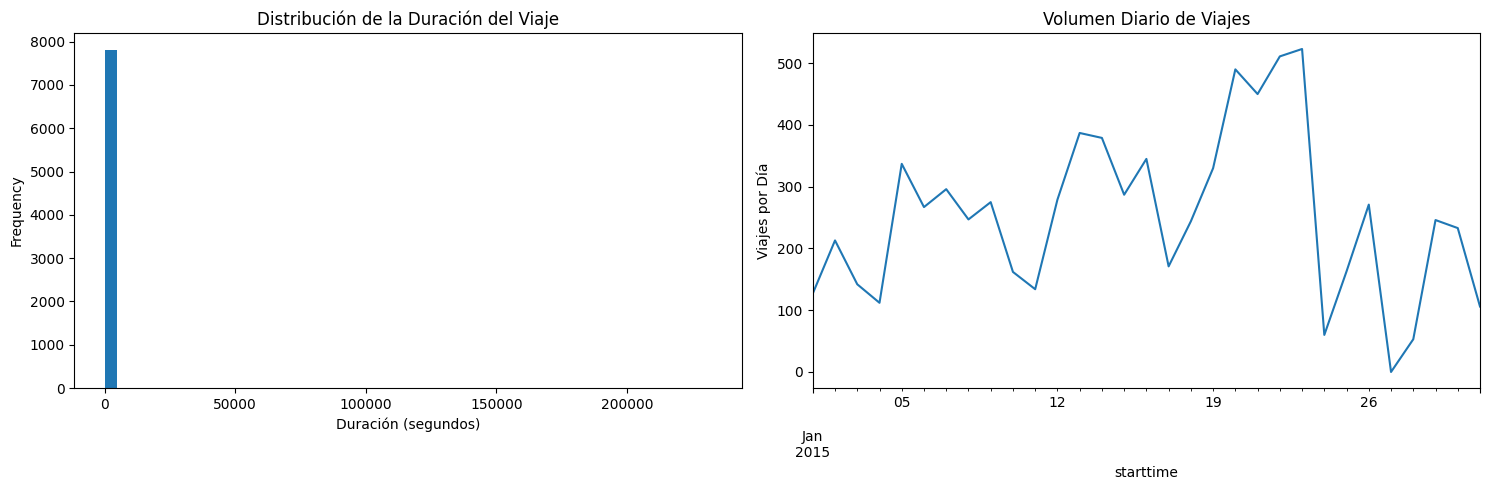

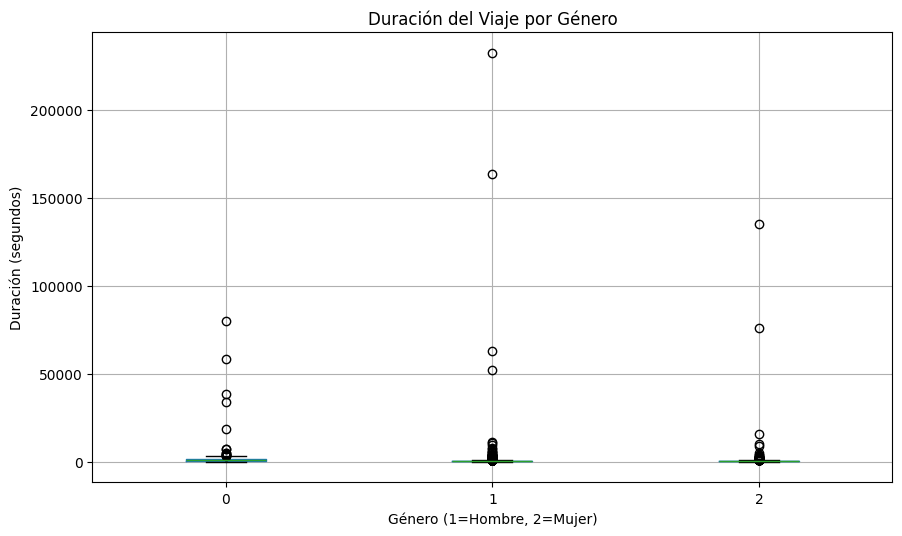

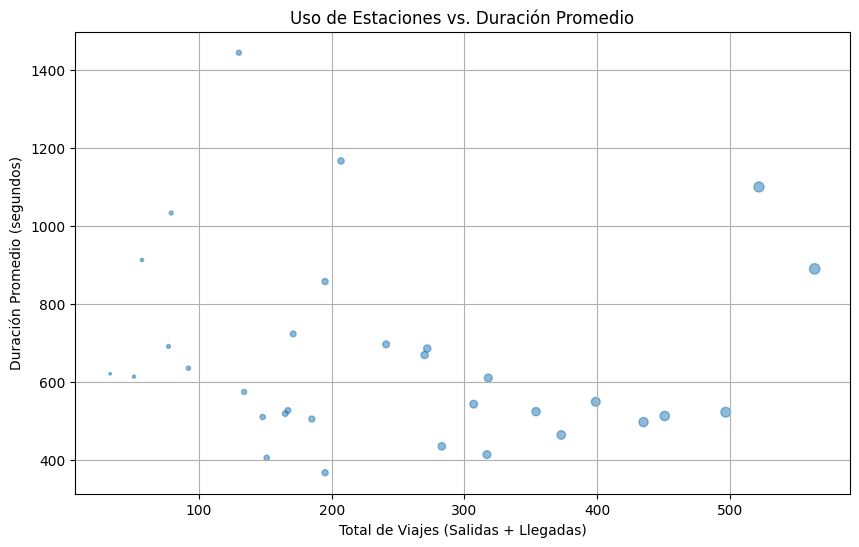

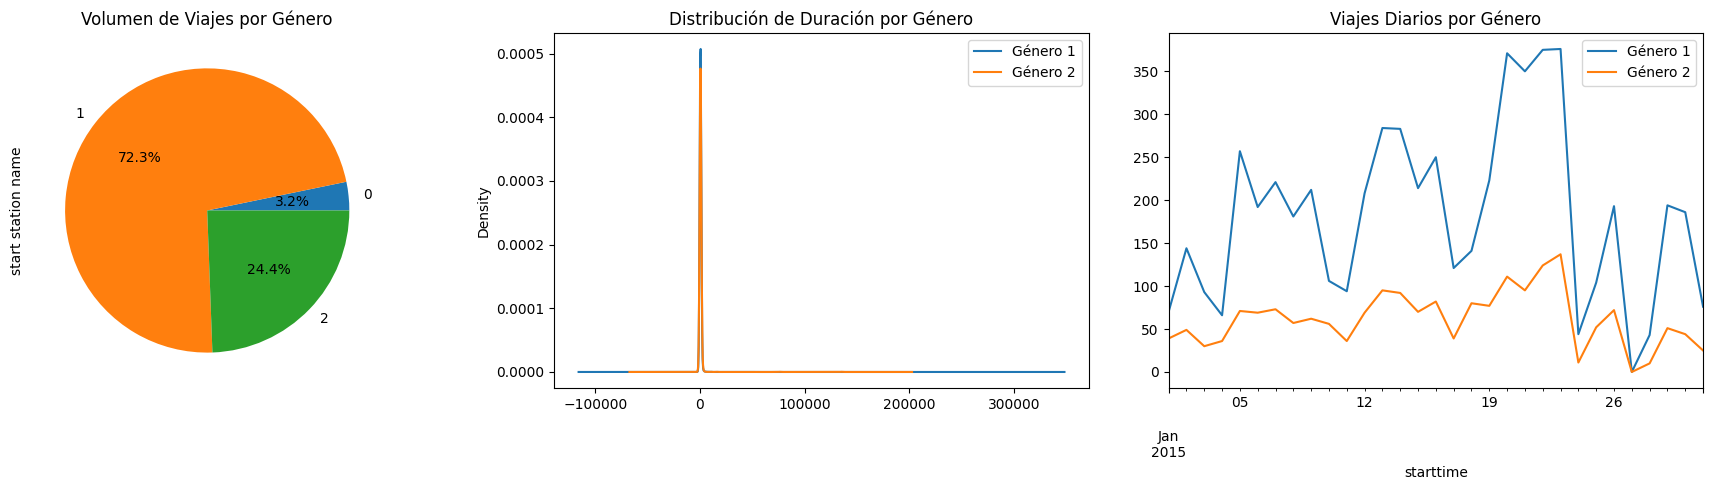

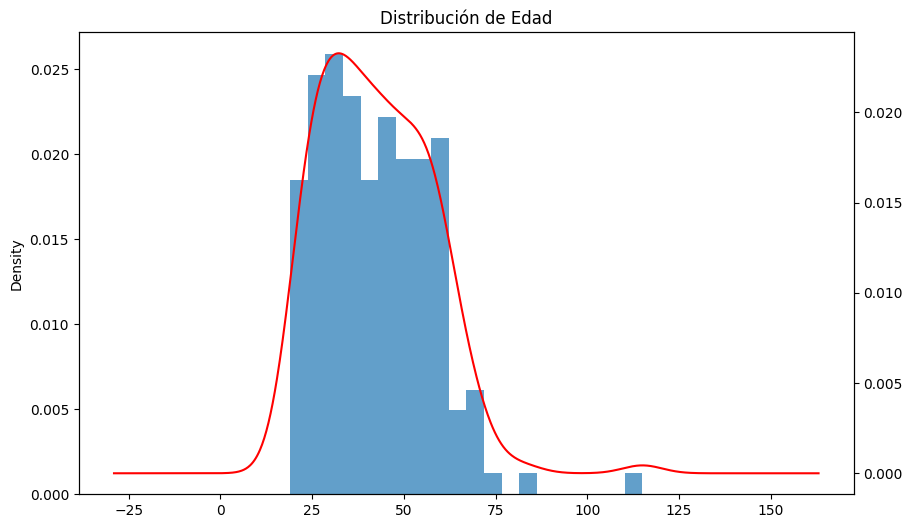

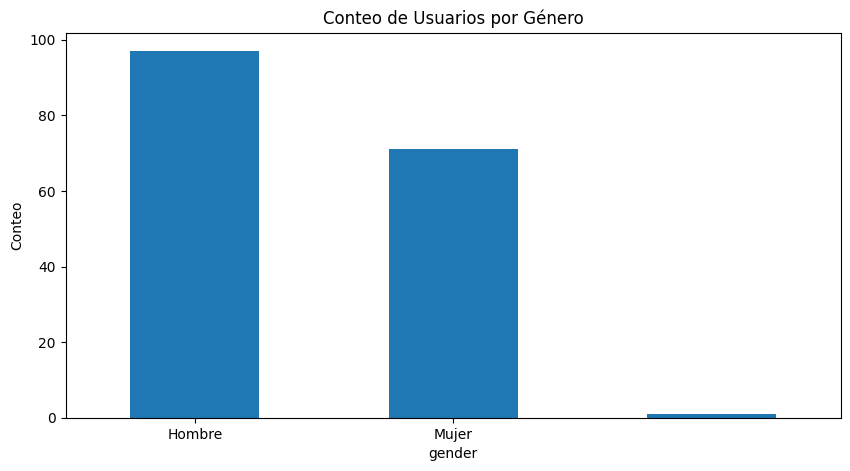

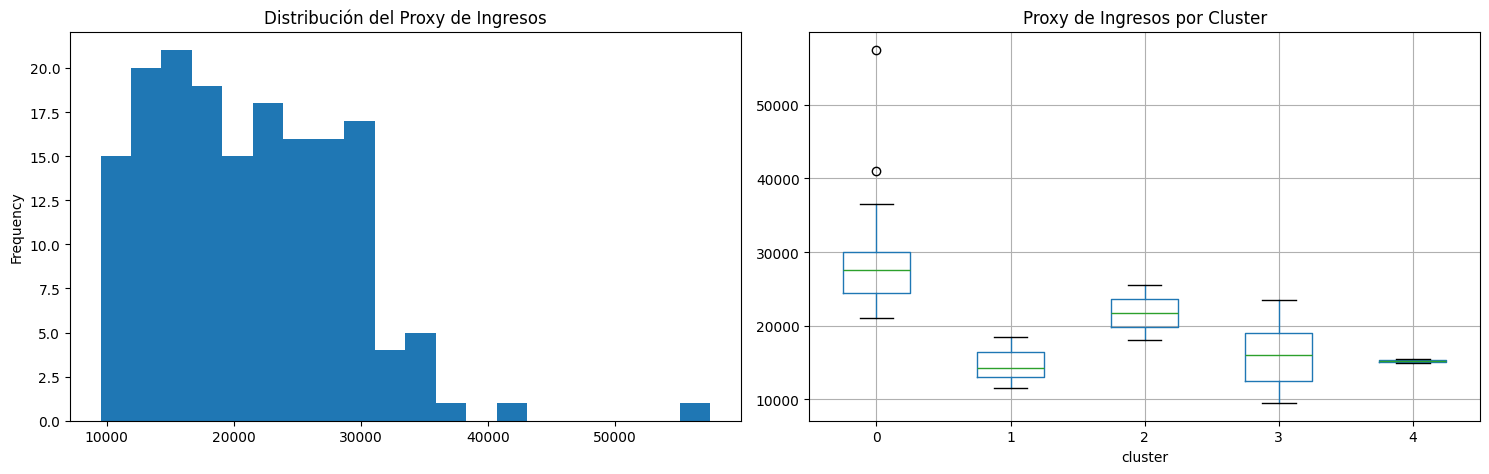

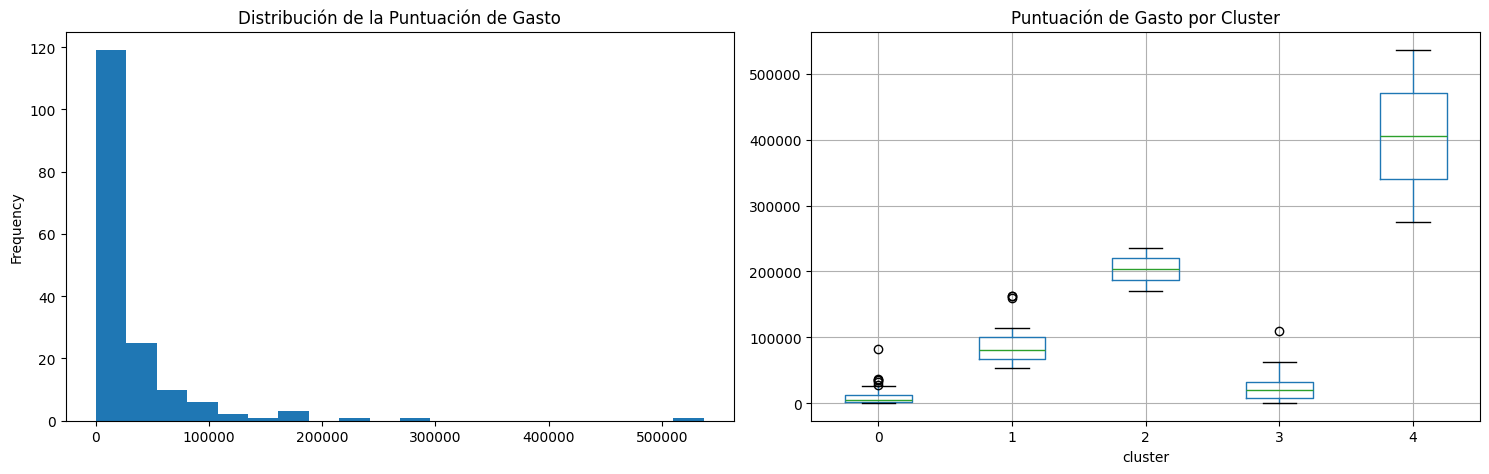

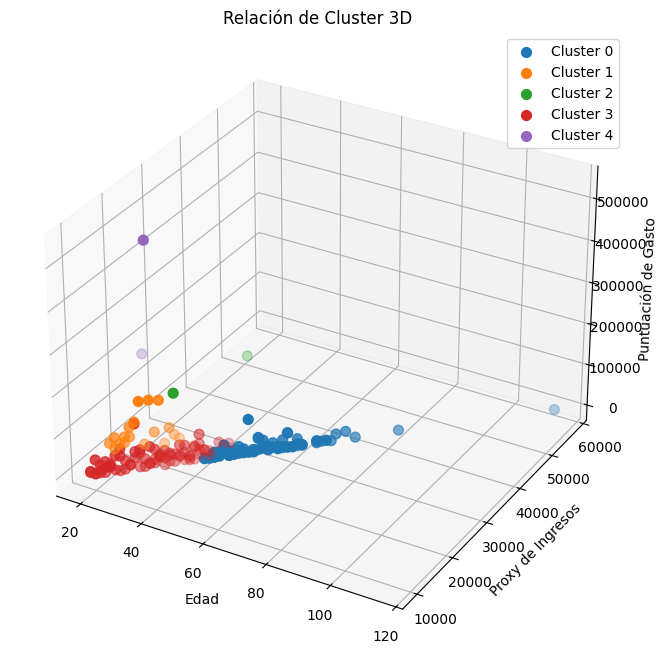

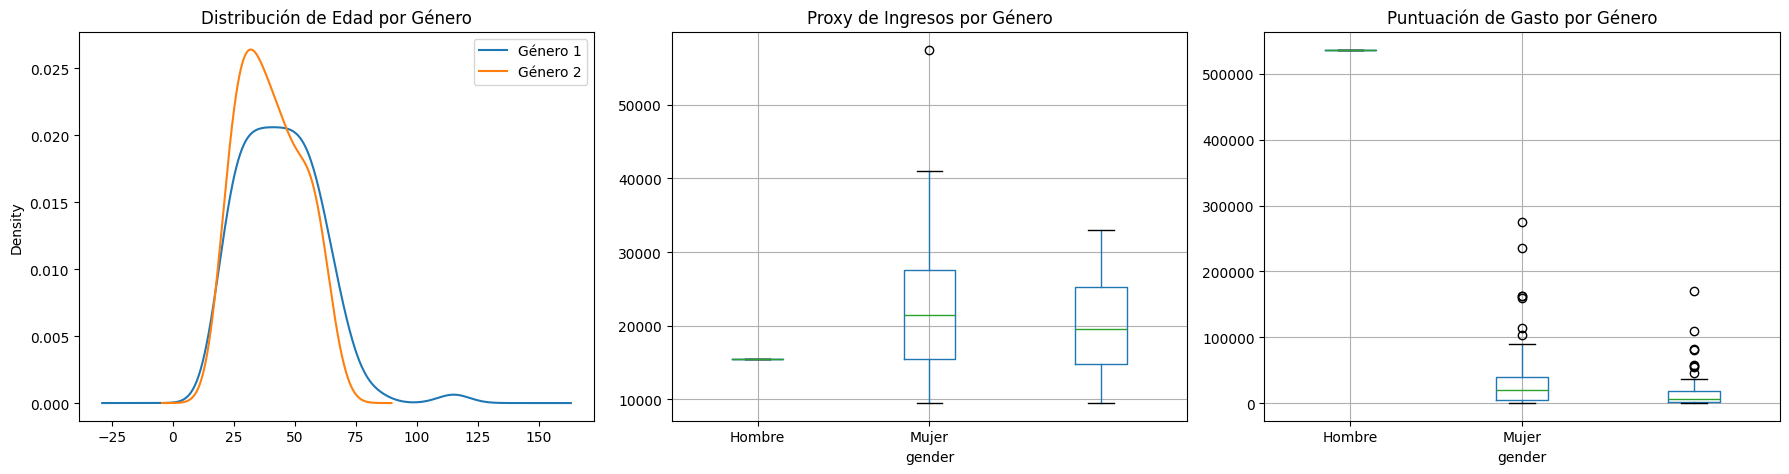

In [40]:
# --- Ejecutar Análisis ---
# Realizar exploración a nivel de viaje
explore_trips(df)

# Realizar visualización a nivel de usuario
visualize_users(user_agg)